# **Flower Classification CNN**

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout ,BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import models

import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train_images = 40591 #number of train images
val_images = 10101 #number of validation images
train_batchsize = 50 #number of train images in each batch
val_batchsize = 50 #number of validation images in each batch
img_shape=(224,224) #image shape

In [3]:
#since the dataset is huge, we use generators to train the model
train_datagen = ImageDataGenerator(rescale=1./255)
x_train = train_datagen.flow_from_directory(
    directory=r'../input/flower-datatree/datatree/train/', #location of train images
    batch_size=train_batchsize,
    target_size=img_shape,
    class_mode="categorical", #classification 
    shuffle=True, #shuffling the train images
    seed=42 #seed for the shuffle
)

validation_datagen = ImageDataGenerator(rescale=1./255)
x_validation = validation_datagen.flow_from_directory(
    directory=r'../input/flower-datatree/datatree/validation/', #location of validation images
    batch_size=val_batchsize,
    target_size=img_shape,
    class_mode="categorical", #classification
    shuffle=True, #shuffling the validation images
    seed=42 #seed for the shuffle
)


Found 40591 images belonging to 102 classes.
Found 10101 images belonging to 102 classes.


In [4]:
#building the model architecture

model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

model.add(Dense(102, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

94658560/94653016 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,796,710
Trainable params: 23,743,590
Non-trainable params: 53,120
_________________________________________________________________


In [5]:
train_steps=int(np.ceil(train_images//train_batchsize)) #number of steps for training the model
val_steps=int(np.ceil(val_images//val_batchsize)) #number of steps for validating the model
print(train_steps,val_steps)

811 202


In [6]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the learning Rate if result is not improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',verbose=1)


In [7]:
savepath="flowermodel.hdf5"
checkpoint = ModelCheckpoint(savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') 
#saves the model only with the highest validation accuracy

In [8]:
start=time.time()
cnn=model.fit_generator(x_train,steps_per_epoch = train_steps,validation_data=x_validation,validation_steps = val_steps,epochs=20,callbacks=[early_stop, reduce_lr , checkpoint],verbose=1)  
end=time.time()

print('training time: '+str(datetime.timedelta(seconds=(end-start))))

Epoch 1/20
811/811 [==============================] - 356s 439ms/step - loss: 0.7498 - acc: 0.7985 - val_loss: 3.5941 - val_acc: 0.2884

Epoch 00001: val_acc improved from -inf to 0.28842, saving model to flowermodel.hdf5
Epoch 2/20
811/811 [==============================] - 326s 402ms/step - loss: 0.1558 - acc: 0.9536 - val_loss: 0.4080 - val_acc: 0.8820

Epoch 00002: val_acc improved from 0.28842 to 0.88200, saving model to flowermodel.hdf5
Epoch 3/20
811/811 [==============================] - 324s 400ms/step - loss: 0.1037 - acc: 0.9690 - val_loss: 0.8308 - val_acc: 0.6956

Epoch 00003: val_acc did not improve from 0.88200
Epoch 4/20
811/811 [==============================] - 324s 400ms/step - loss: 0.0712 - acc: 0.9792 - val_loss: 0.2329 - val_acc: 0.9264

Epoch 00004: val_acc improved from 0.88200 to 0.92638, saving model to flowermodel.hdf5
Epoch 5/20
811/811 [==============================] - 323s 398ms/step - loss: 0.0696 - acc: 0.9794 - val_loss: 0.2182 - val_acc: 0.9292

Epoc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


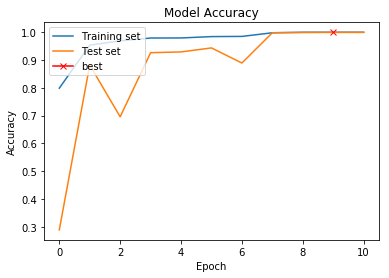

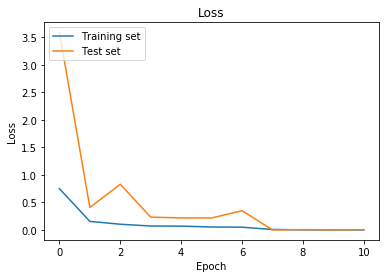

In [9]:
#accuracy
print(cnn.history.keys())
plt.plot(cnn.history['acc'])
plt.plot(cnn.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(np.argmax(cnn.history["val_acc"]), np.max(cnn.history["val_acc"]), marker="x", color="r",label="best model")
plt.legend(['Training set', 'Test set','best'], loc='upper left')
plt.show()

#loss
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

# **Predciting test data using the trained model**

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
x_test = test_datagen.flow_from_directory(
    directory=r'../input/flower-datatree/datatree/',
    target_size=img_shape,
    classes=['test'],
    batch_size=1,
    shuffle=False
)

Found 2009 images belonging to 1 classes.


In [11]:
test_images = 2009

test_stepsize = test_images
x_test.reset() #
predict = model.predict_generator(x_test ,steps=test_stepsize , verbose=1)
print(predict)

2009/2009 [==============================] - 28s 14ms/step
[[8.0177529e-16 5.2588299e-17 1.1371293e-15 ... 4.3500967e-13
  1.8330418e-05 3.1954911e-11]
 [1.8883219e-07 4.4485281e-13 1.7704398e-14 ... 1.3758020e-06
  1.6046554e-12 3.2184135e-13]
 [1.9805233e-07 1.0196191e-13 2.8203309e-10 ... 7.7692105e-04
  6.7728818e-09 6.3231454e-08]
 ...
 [5.6849391e-08 2.8421940e-14 3.7241236e-08 ... 1.0566724e-03
  6.6066729e-03 4.7926053e-05]
 [5.1864423e-18 1.0115157e-26 8.4832464e-20 ... 4.1592916e-18
  5.6243225e-11 1.4062984e-16]
 [5.1993390e-15 2.5627806e-21 1.9357501e-14 ... 2.4378635e-14
  5.5829417e-11 4.2685883e-26]]


In [12]:
predict.shape

(2009, 102)

In [13]:
predictions=[] #saving all the prediction on the test images
for i in predict:
    predictions.append(np.argmax(i)+1)

In [14]:
#undoing the sorting of the categories caused by ImageDataGenerator
####very very important####
actual=[str(i) for i in range(1,103)]
gen=sorted(actual)

labels={}

for i in range(1,103):
    labels[i]=int(gen[i-1])
n_predictions=[]
for i in predictions:
    n_predictions.append(labels[i])

predictions = n_predictions

In [15]:
from collections import Counter
freq=Counter()
freq.update(predictions)

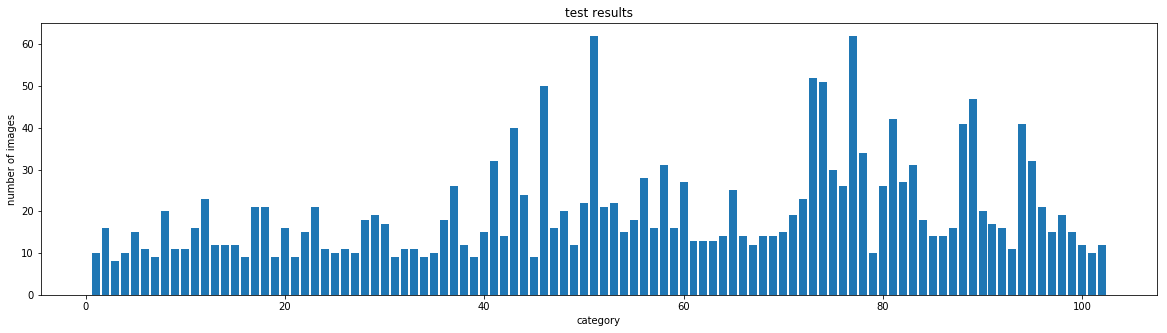

In [16]:
import matplotlib.pylab as plt

lists = sorted(freq.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(20,5))
plt.bar(x, y)
plt.xlabel('category')
plt.ylabel('number of images')
plt.title("test results")
plt.show()

In [17]:
names=[i for i in range(18540,20549)]
results = pd.Series(predictions,name = "category")
names=pd.Series(names,name = "image_id")
submission = pd.concat([names,results],axis = 1)
submission.to_csv("output.csv",index=False)